### Import dependencies

In [4]:
import os
import numpy as np
import albumentations as A
import torch
import random
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, random_split, DataLoader
from skimage import io, transform

### Load Datasets

In [5]:
base_dir = "data/"
train_dir = os.path.join(base_dir, "stage1_train")

In [6]:
def get_train_transform():
    return A.Compose(
        [
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            ToTensorV2(),
        ]
    )


class LoadDataSet(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_train_transform()

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], "images/")
        mask_folder = os.path.join(self.path, self.folders[idx], "masks/")
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

        img = io.imread(image_path)[:, :, :3].astype("float32")
        img = transform.resize(img, (256, 256))
        mask = self.get_mask(mask_folder, 256, 256).astype("float32")

        augmented = self.transforms(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"]
        mask = torch.permute(mask, (2, 0, 1))
        return (img, mask)

    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis=-1)
            mask = np.maximum(mask, mask_)

        return mask

In [7]:
train_dataset = LoadDataSet(train_dir, transform=get_train_transform())

In [8]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

print(type(image))
print(type(mask))

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


/var/folders/2b/fj5vstp97x35l3074sbvys100000gn/T/ipykernel_51203/2709637516.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [9]:
train_dataset.__len__()

670

### Visualize images

In [10]:
def format_image(img):
    img = np.array(np.transpose(img, (1, 2, 0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img = std * img + mean
    img = img * 255
    img = img.astype(np.uint8)
    return img


def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1, 2, 0)))
    return mask

In [11]:
def visualize_dataset(n_images, predict=None):
    """
    Function to visualize images and masks
    """
    images = random.sample(range(0, 670), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset.__getitem__(img_no)
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title("Ground Truth Image")
        ax[i, 1].set_title("Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

[249, 337, 523, 81, 453]


/var/folders/2b/fj5vstp97x35l3074sbvys100000gn/T/ipykernel_41767/2709637516.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


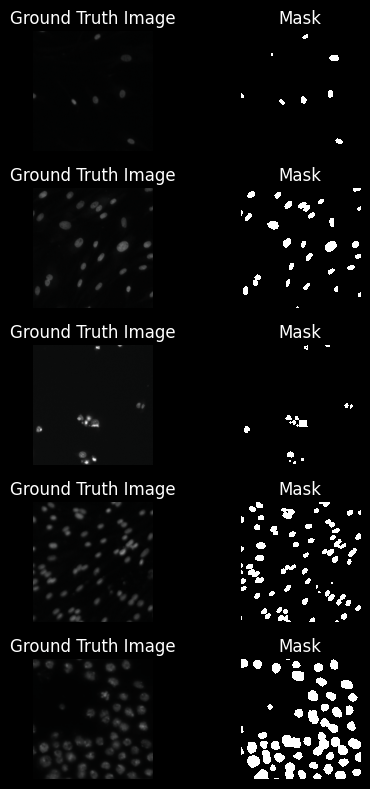

In [29]:
visualize_dataset(5)

### Split train and validation set

In [26]:
split_ratio = 0.25
train_size = int(np.round(train_dataset.__len__() * (1 - split_ratio), 0))
valid_size = int(np.round(train_dataset.__len__() * split_ratio, 0))

train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=10)

print(
    "Length of train and valid datas: {}, {}".format(len(train_data), len(valid_data))
)

Length of train and valid datas: 502, 168


### Load TestSet

In [13]:
test_dir = os.path.join(base_dir, "stage1_test")

In [14]:
def get_test_transform():
    return A.Compose(
        [
            A.Resize(256, 256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )


class LoadTestSet(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_test_transform()

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], "images/")
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])

        img = io.imread(image_path)[:, :, :3].astype("float32")
        img = transform.resize(img, (256, 256))

        augmented = self.transforms(image=img)
        img = augmented["image"]
        return img

In [15]:
test_dataset = LoadTestSet(train_dir, transform=get_test_transform())

In [16]:
image = test_dataset.__getitem__(0)
print(image.shape)
print(type(image))

torch.Size([3, 256, 256])
<class 'torch.Tensor'>


### Visualize prediction

In [17]:
from model import RPAResUNet

DEVICE = torch.device("cpu")
if os.path.exists("rdouplenet.pt"):
    model = RPAResUNet(num_classes=1).to(DEVICE)
    model.load_state_dict(torch.load("rdouplenet.pt", map_location=DEVICE))
    print("Loaded ResUNet from this run.")

Loaded ResUNet from this run.


In [20]:
def format_image(img):
    img = img.clone().cpu().numpy()
    img = np.transpose(img, (1,2,0))
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img
def format_mask(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

/var/folders/2b/fj5vstp97x35l3074sbvys100000gn/T/ipykernel_51203/2709637516.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


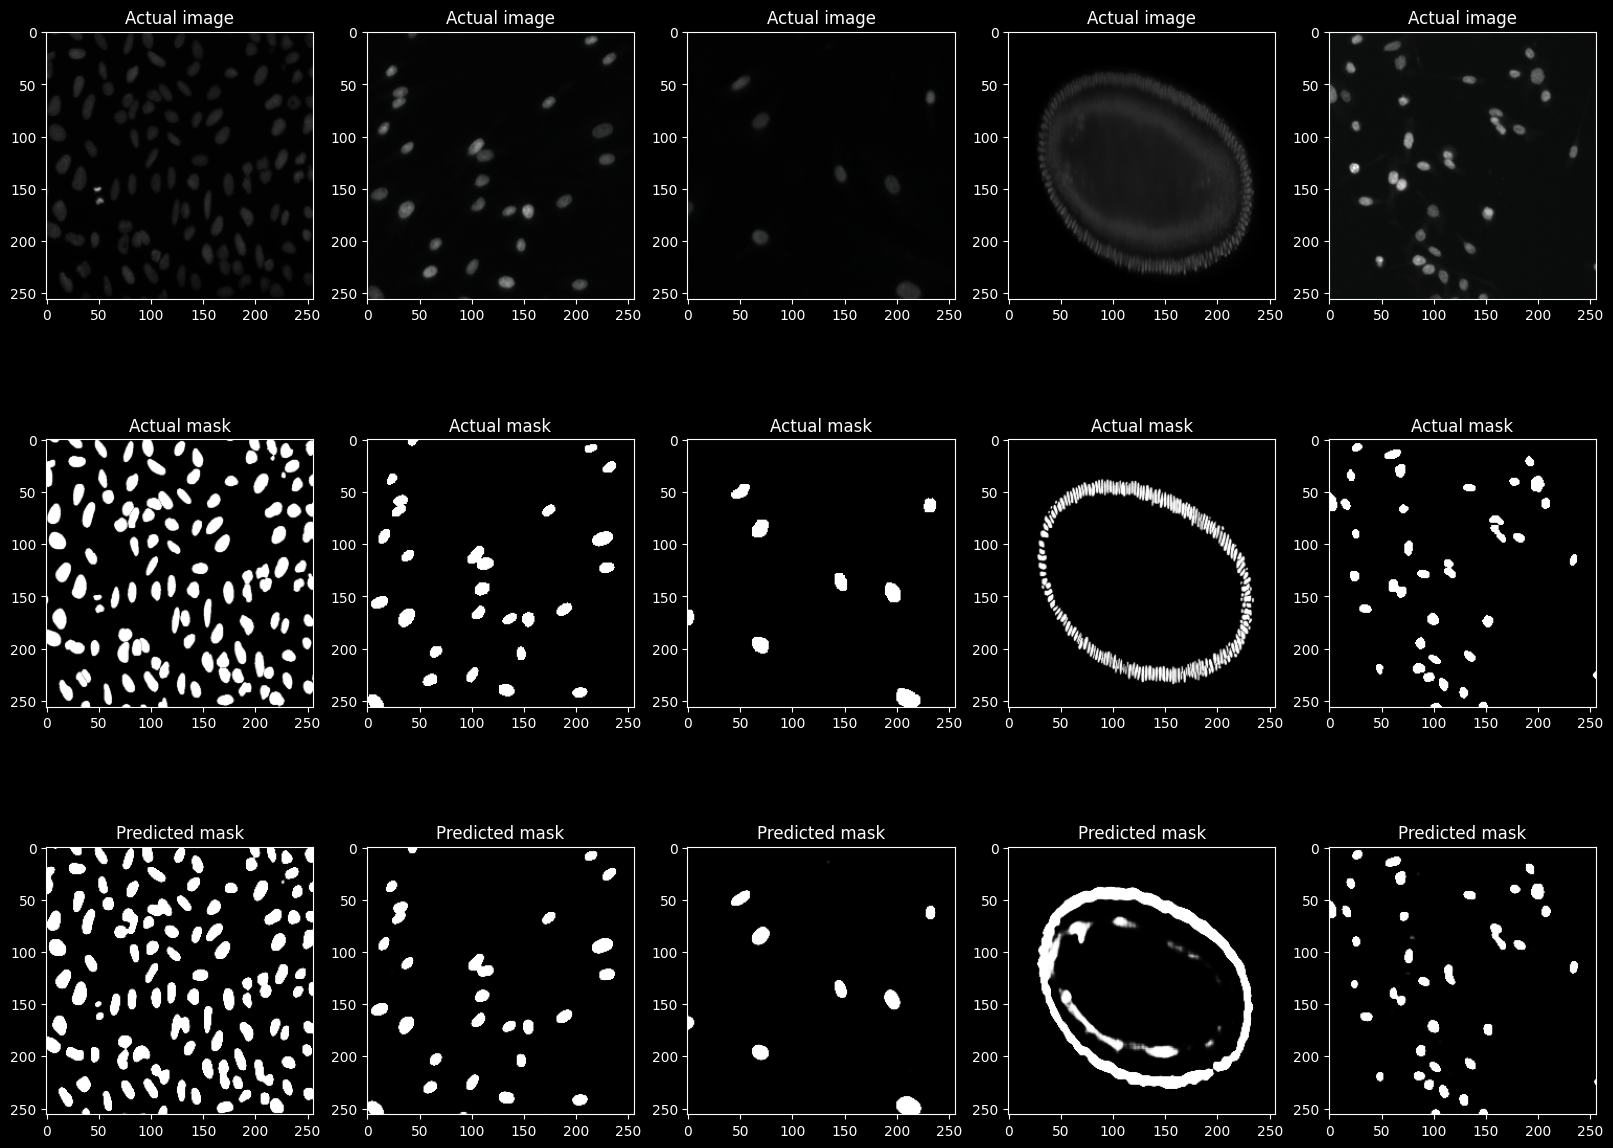

In [24]:
# Visualize predictions
iter_ = iter(valid_loader)
image, mask = next(iter_)
image = image.to(DEVICE, dtype=torch.float)
mask = mask.to(DEVICE, dtype=torch.float)

y_pred = model.forward(image)

plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(format_image(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(format_mask(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(format_mask(y_pred[i]),cmap='gray')
plt.show()

### Reference
https://www.kaggle.com/code/arunmohan003/unet-starter-pytorch